In [1]:
%%capture output
!pip install brian2
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -y -n opensim_env python=3.10
!source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && conda install -y -c opensim-org opensim pandas
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/activation.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/muscle_sim.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/neural_simulations.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/plot_time_series.py



In [6]:
#%%capture output
!unzip Model.zip

Archive:  Model.zip
replace Model/lumbar3.vtp? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import numpy as np
import pandas as pd
import os
import subprocess
import tempfile
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from collections import defaultdict

from plot_time_series import plot_times_series
from neural_simulations import run_neural_simulations
from activation import decode_spikes_to_activation


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
t_reaction = 40*ms
n_loop=2
dt = 0.1*ms

neuron_population = {"Ia": 100, "II": 100, "exc": 100, "motor": 100}
ees_params={
    'ees_freq':50*hertz,
    'aff_recruited':1,
    'eff_recruited':1}
biophysical_params={
    'p':0.4,
    'w':15*uS,
    'T_refr':2*ms
}

initial_values_decoding_spikes={i: {'u0': [0.0, 0.0], 'c0': [0.0, 0.0], 'P0':[0.0], 'a0':[0.0]} for i in range(neuron_population["motor"])}

muscle_name = "iliacus_r"

stretch_initial, velocity_initial = np.zeros(int(t_reaction/dt)), np.zeros(int(t_reaction/dt))
stretch, velocity=stretch_initial, velocity_initial

name_output_spikes = 'spikes.json'
name_output_muscle='df_muscle.csv'
data_muscle = []
data_spikes = {
    "Ia": defaultdict(list),
    "II": defaultdict(list),
    "MN": defaultdict(list)
}
resting_length=None
results_folder = 'results'
os.makedirs(results_folder, exist_ok=True)
final_states_opensim=os.path.join(results_folder, 'final.json')

for j in range(n_loop):

    print(f"--- Iteration {j+1} ---")
    spikes_all=run_neural_simulations(stretch, velocity, neuron_population,dt,t_reaction, **ees_params, **biophysical_params)
    print("len_spikes ", len(spikes_all['MN']))
    for fiber_name, fiber_spikes in spikes_all.items():
      for neuron_id, spikes in fiber_spikes.items():
        data_spikes[fiber_name][neuron_id].extend(spikes/second+j*t_reaction/second)

    if len(spikes_all["MN"])==0:
        print("No spikes in MN")
        mean_e=np.zeros(int(t_reaction/dt))
        mean_u = np.zeros(int(t_reaction/dt))
        mean_c = np.zeros(int(t_reaction/dt))
        mean_P = np.zeros(int(t_reaction/dt))
        mean_activation=np.zeros(int(t_reaction/dt))
        initial_values_decoding_spikes={i: {'u0': [0.0, 0.0], 'c0': [0.0, 0.0], 'P0':[0.0], 'a0':[0.0]} for i in range(neuron_population["motor"])}

    else:
        e,u,c,P,activations, final_values=decode_spikes_to_activation([value/second for key, value in spikes_all["MN"].items()], dt/second, t_reaction/second, initial_values_decoding_spikes)
        mean_activation = np.mean(activations, axis=0)
        mean_e=np.mean(e, axis=0)
        mean_u = np.mean(u, axis=0)
        mean_c = np.mean(c, axis=0)
        mean_P = np.mean(P, axis=0)

        initial_values_decoding_spikes = {
    i: final_values[i] if i in final_values else {'u0': [0.0, 0.0], 'c0': [0.0, 0.0], 'P0': [0.0], 'a0': [0.0]}
    for i in range(neuron_population['motor'])
}
    # Create temporary files for both input and output
    with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as input_tmp, \
        tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as output_tmp:

        input_path = input_tmp.name
        output_path = output_tmp.name
        np.save(input_path, mean_activation)


        cmd = [
            'conda', 'run', '-n', 'opensim_env', 'python', 'muscle_sim.py',
            '--dt', str(dt/second),
            '--T', str(t_reaction/second),
            '--muscle', muscle_name,
            '--activation', input_path,
            '--output_stretch', output_path,
            '--output_final_state', final_states_opensim]
        if j>0:
          cmd += ['--initial_state', final_states_opensim]

        # Run the process in the other environment
        process = subprocess.run(cmd, capture_output=True, text=True)

        if process.stdout.strip():
            print("STDOUT:\n", process.stdout)

        if process.returncode == 0 and os.path.getsize(output_path) > 0:
            fiber_length=np.load(output_path)[1:]
            if j==0:
              resting_length=fiber_length[0]
            stretch=fiber_length/resting_length-1
            velocity=np.gradient(stretch, np.arange(0, t_reaction, dt))

            # Create batch data dictionary
            batch_data_muscle = {
              #**{f'activation_{i}': activations[i] for i in range(neuron_population['motor'])},
              'mean_e': mean_e,
              'mean_u': mean_u,
              'mean_c': mean_c,
              'mean_P': mean_P,
              'mean_activation': mean_activation,
              'fiber_length': fiber_length,
              'stretch': stretch,
              'velocity': velocity
            }
            data_muscle.append(pd.DataFrame(batch_data_muscle))
        else:
          raise RuntimeError(f'Problem in iteration {j}. STDERR: {process.stderr}')

        # Clean up temporary files
        os.unlink(input_path)
        os.unlink(output_path)

df_muscle = pd.concat(data_muscle)
df_muscle['Time']=np.arange(0, len(df_muscle)*dt, dt)
path_muscle= os.path.join(results_folder, name_output_muscle)
df_muscle.to_csv(path_muscle, index=False)
print(f'{path_muscle} saved')

path_spikes = os.path.join(results_folder, name_output_spikes)
with open(path_spikes, "w") as f:
    json.dump(data_spikes, f, indent=4)
print(f'{path_spikes} saved')

if os.path.isfile(final_states_opensim):
    os.remove(final_states_opensim)
    print(f"Deleted: {final_states_opensim}")



--- Iteration 1 ---
moto_spike_dict {0: array([10.9, 12.9, 17.8, 26. , 34.5, 38.2]) * msecond, 1: array([11.5, 16.3, 24.3, 32.5, 36.3]) * msecond, 2: array([ 4.1, 11.8, 15.9, 25. , 32.6, 37.2]) * msecond, 3: array([ 4.8, 12.6, 21.5, 33.2, 37.7]) * msecond, 4: array([11.9, 14.7, 20. , 25.3, 32.3, 35.3]) * msecond, 5: array([12.4, 16. , 24.8, 32.1, 35.5, 39.3]) * msecond, 6: array([ 4.3, 13.3, 18.5, 26.3, 29.5, 33.9, 39.2]) * msecond, 7: array([12.4, 19. , 25. , 30. , 35.9]) * msecond, 8: array([ 3.4, 12.3, 17.2, 25.4, 30.3, 33.8, 39.3]) * msecond, 9: array([11.8, 15.5, 22.5, 28.1, 34.4, 37.3]) * msecond, 10: array([13.1, 16.4, 24.2, 32.1, 36. ]) * msecond, 11: array([13.4, 23.9, 31.9, 37.7]) * msecond, 12: array([ 4.1, 11.5, 14.8, 19.4, 25.6, 32.7, 36.7]) * msecond, 13: array([11.7, 15.8, 25.1, 33.3, 37.5]) * msecond, 14: array([ 2.5, 13. , 17.1, 23.9, 32.3, 36.7]) * msecond, 15: array([ 4. , 12.3, 15.7, 25. , 32.4, 36.3]) * msecond, 16: array([11.9, 16.6, 18.9, 24.8, 32.2, 36.9]) * mse

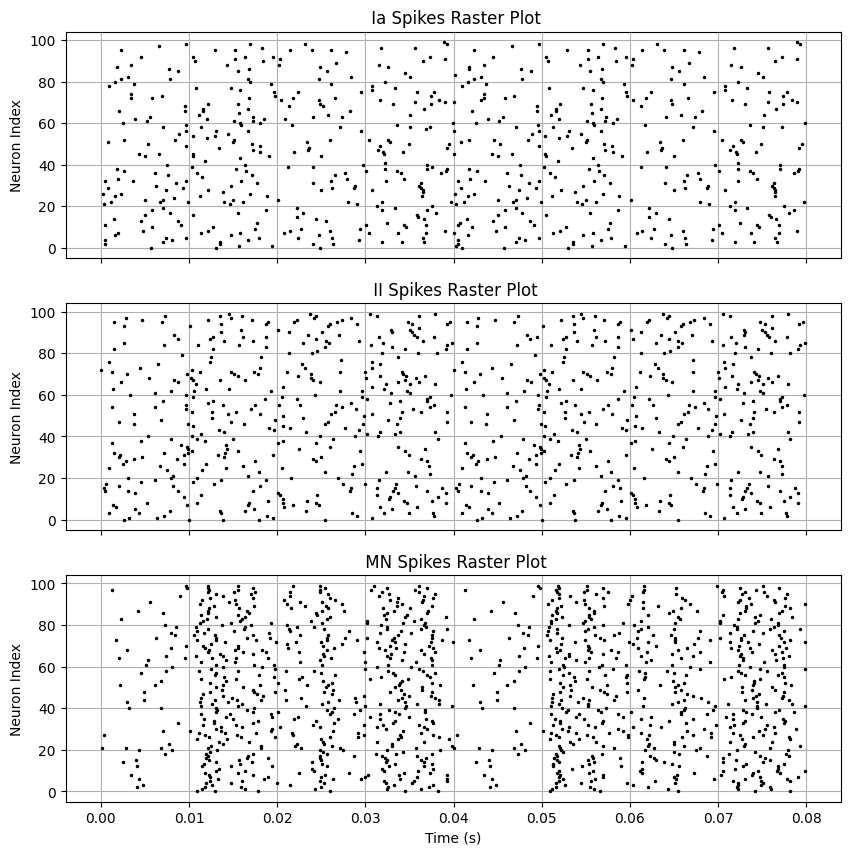

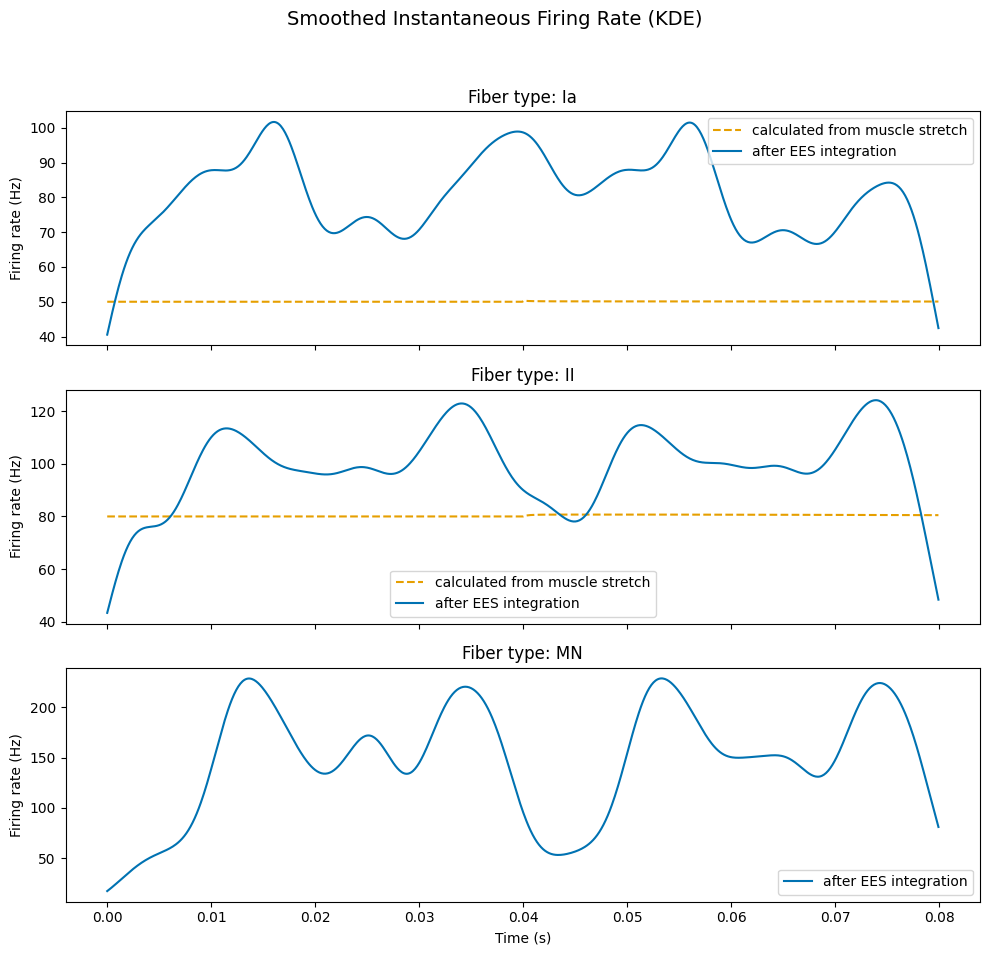

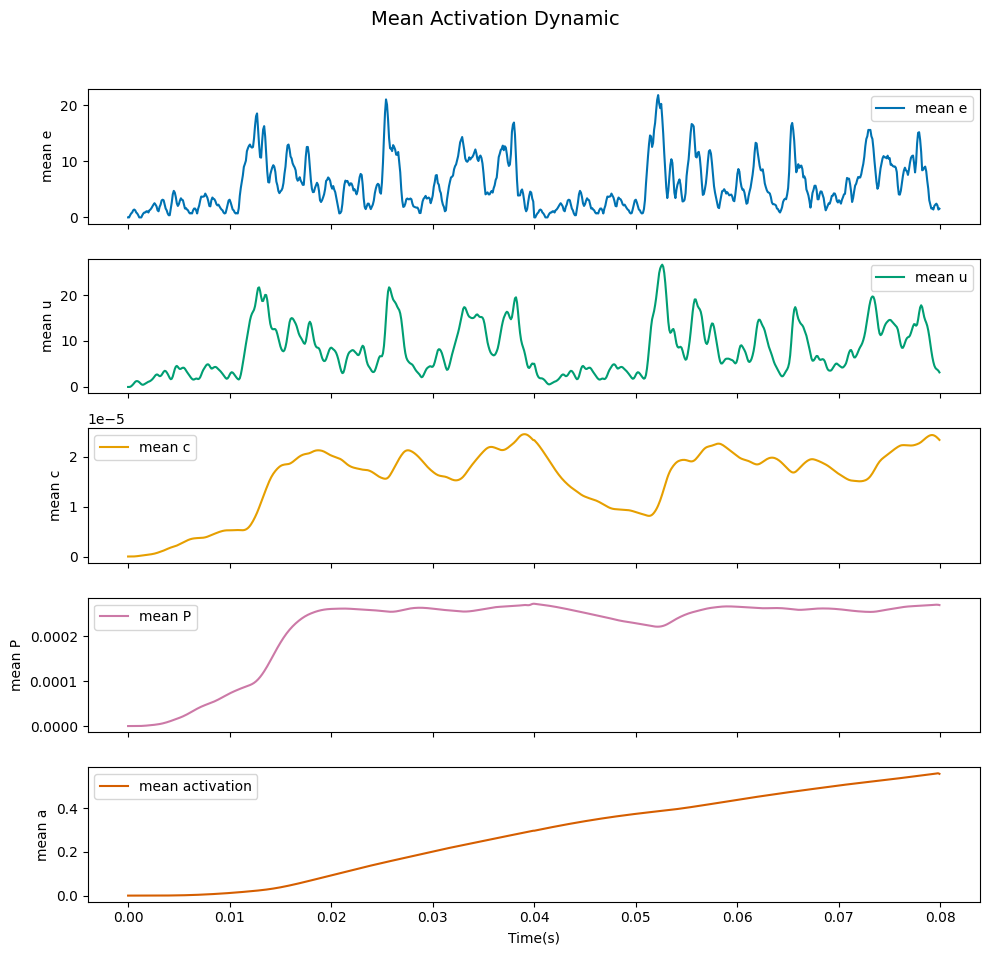

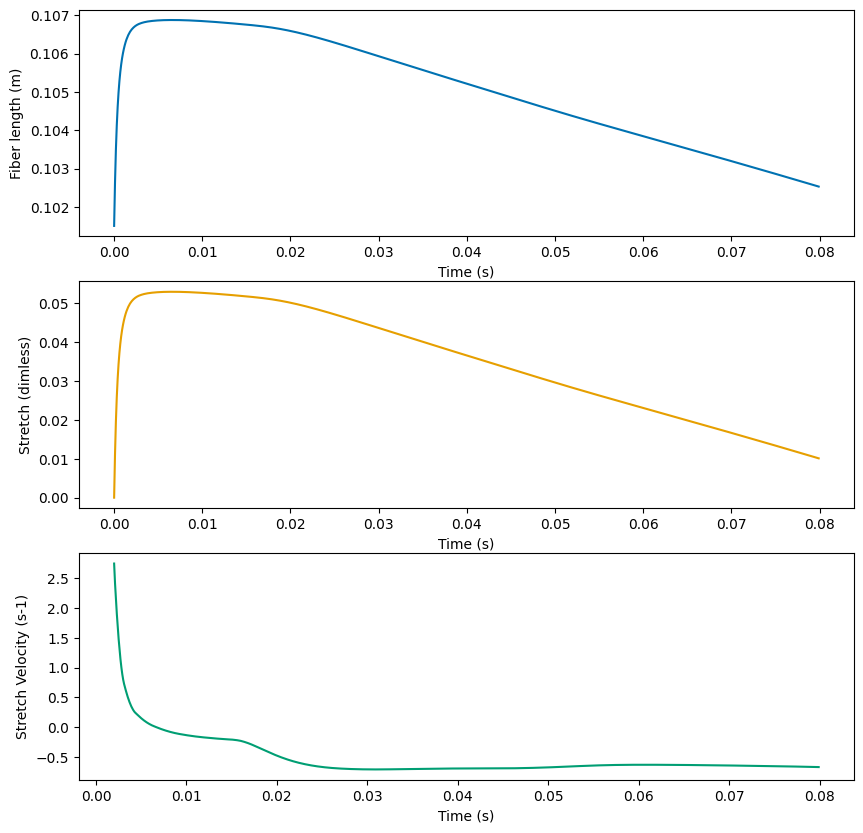

In [59]:
plot_times_series(np.arange(0, t_reaction, dt),stretch_initial,path_spikes, path_muscle, results_folder,**ees_params )


In [52]:
sto_name='muscle.sto'
sto_file= os.path.join(results_folder, sto_name)
#Compute the sto file with the entire simulation for all the variables
with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as input_tmp:

    input_path = input_tmp.name
    np.save(input_path, df_muscle['mean_activation'])
    cmd = [
            'conda', 'run', '-n', 'opensim_env', 'python', 'muscle_sim.py',
            '--dt', str(dt/second),
            '--T', str(t_reaction/second*n_loop),
            '--muscle', muscle_name,
            '--activation', input_path,
            '--output_all', sto_file
          ]

    # Run the process in the opensim environment
    process = subprocess.run(cmd, capture_output=True, text=True)

    if process.stdout.strip():
          print("STDOUT:\n", process.stdout)
    if process.stderr.strip():
          print(f"STDERR: {process.stderr}")

STDOUT:
 [info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim
results/muscle.sto file is saved




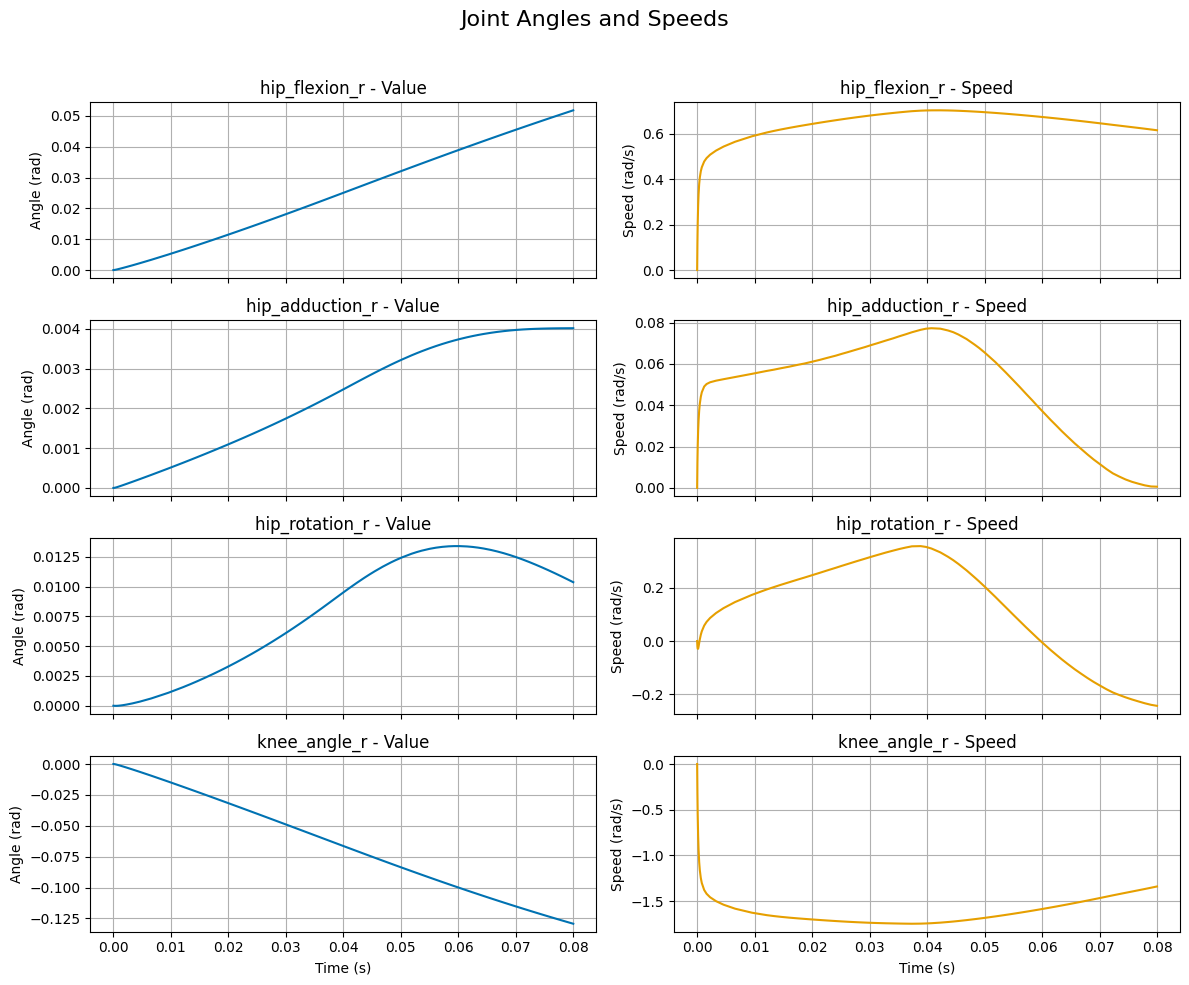

In [53]:
from plot_time_series import plot_joint_angle_from_sto_file as pja
# Define columns of interest
columns_wanted = [
    "hip_flexion_r",
    "hip_adduction_r",
    "hip_rotation_r",
    "knee_angle_r"
]
pja(sto_file, columns_wanted, results_folder, **ees_params)